In [1]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sc_query import load_documents
from sc_query import search_documentlist
from sc_query import result_markdown_formater
from sc_query import collect_matika_cooccurences_pivot
from sc_query import query_keywordlist
from sc_query import query_regex


## 1. Loading suttas from suttacentral github image

Clone the `suttacentral-data` repository.

```bash
git clone https://github.com/suttacentral/suttacentral-data.git
```

Set the `rootdir` variable accordingly.


In [2]:
rootdir = "/home/jeff/dev/datayana/suttacentral-data/text/pi/su"

docs = load_documents(rootdir)
print("loaded {} files, total bytes {}".format(len(docs), sum([len(entry["html_content"]) for entry in docs])))

loaded 5739 files, total bytes 28469442


## 2. Querying a list of simple keywords

Create a query made of just a list of keywords. Function `query_wordlist()` constructs the query by taking a list of keywords.

In [11]:
kwquery = query_keywordlist([
            "anussavena", "paramparāya", "itikirāya", "piṭaka­sam­padā­nena",
            "takkahetu", "nayahetu", "ākāra­pari­vitak­kena", "diṭṭhi­nij­jhā­nak­khan­tiyā",
            "bhabbarūpatāya", "samaṇo no garū"        
    ])

results_kwquery = search_documentlist(kwquery, docs, sort="score")
print("Results found: {}".format(len(results_kwquery)))


Results found: 20


Creating a markdown file that shows those results

In [12]:
with open("output/test_results-kwlist.md", "w") as ofile:
    ofile.write(result_markdown_formater(kwquery, results_kwquery))

## 3. Querying a list of alternatives

If each word can be found in multiple variants, create a list of alternatives.

Here's how to construct the query:

In [13]:
altquery = {
    "alternatives_list": [
        { "label": "anussavena", "forms": ["anussavena", "anussavā", "itihitihaṃ", "itihītihaṃ"] },
        { "label": "paramparāya", "forms": ["paramparāya"] },
        { "label": "itikirāya", "forms": ["itikirāya", "itikiriyāya"] },
        { "label": "piṭakasampadānena", "forms": ["piṭakasampadānena", "piṭakasampadāya"] },
        { "label": "takkahetu", "forms": ["takkahetu"] },
        { "label": "nayahetu", "forms": ["nayahetu"] },
        { "label": "ākāraparivitakkena", "forms": ["ākāraparivitakkena", "ākāraparivitakkā"] },
        { "label": "diṭṭhinijjhānakkhantiyā", "forms": ["diṭṭhinijjhānakkhantiyā"] },
        { "label": "bhabbarūpatāya", "forms": ["bhabbarūpatāya"] },
        { "label": "samaṇo no garū", "forms": ["samaṇo no garū"] }
    ]
}

results_altquery = search_documentlist(altquery, docs, sort="score")
print("Results found: {}".format(len(results_altquery)))

with open("output/test_results-altlist.md", "w") as ofile:
    ofile.write(result_markdown_formater(altquery, results_altquery))

Results found: 27


## 4. Showing matika co-occurences

/home/jeff/local/anaconda2/envs/datayana/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


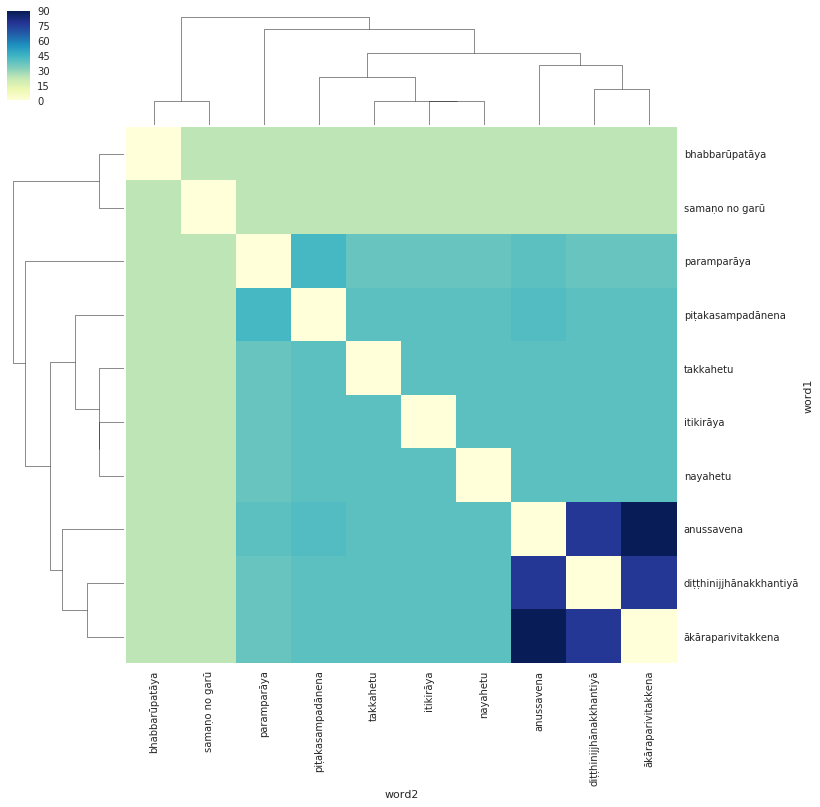

In [14]:
df_pivot = collect_matika_cooccurences_pivot(results_altquery)

rcmd_figsize = (df_pivot.shape[0]+2,df_pivot.shape[1]+2)

sns.set(color_codes=True)

g = sns.clustermap(df_pivot,
                   method="complete", metric="jaccard",
                   cmap="YlGnBu",
                   figsize=rcmd_figsize)

g.savefig("output/img/test_matika_cooccurences.png")

## 5. Test other examples

In [15]:
from sc_query import collect_matika_cooccurences_counter
import pandas as pd

altquery = {
    "alternatives_list": [
        { "label": "dukkha", "forms": ["dukkh"] },
        { "label": "nirodha", "forms": ["nirodh"] },
        { "label": "samudaya", "forms": ["samuday"] },
        { "label": "magga", "forms": ["magga"] },
        { "label": "anicca", "forms": ["anicca"] },
        { "label": "anatta", "forms": ["anatta"] },
        { "label": "rupa", "forms": ["rūpa", "rūpā"] },
        { "label": "vedana", "forms": ["vedana", "vedanā"] },
        { "label": "sanna", "forms": ["saññā", "sañña"] },
        { "label": "sankhara", "forms": ["sankhārā", "saṅkhāra", "sankhar", "sankhār"] },
        { "label": "vijnana", "forms": ["viññāṇaṃ", "viññāṇ"] }
    ]
}

results_altquery = search_documentlist(altquery, docs, sort="score")
print("Results found: {}".format(len(results_altquery)))

Results found: 2756


In [16]:
import math

#df_pivot = collect_matika_cooccurences_pivot(results_altquery,
#                                             transform=lambda v : 1 / (1+math.log(v)),
#                                             normalize="minmax")

df_pivot = collect_matika_cooccurences_pivot(results_altquery)

#df_pivot

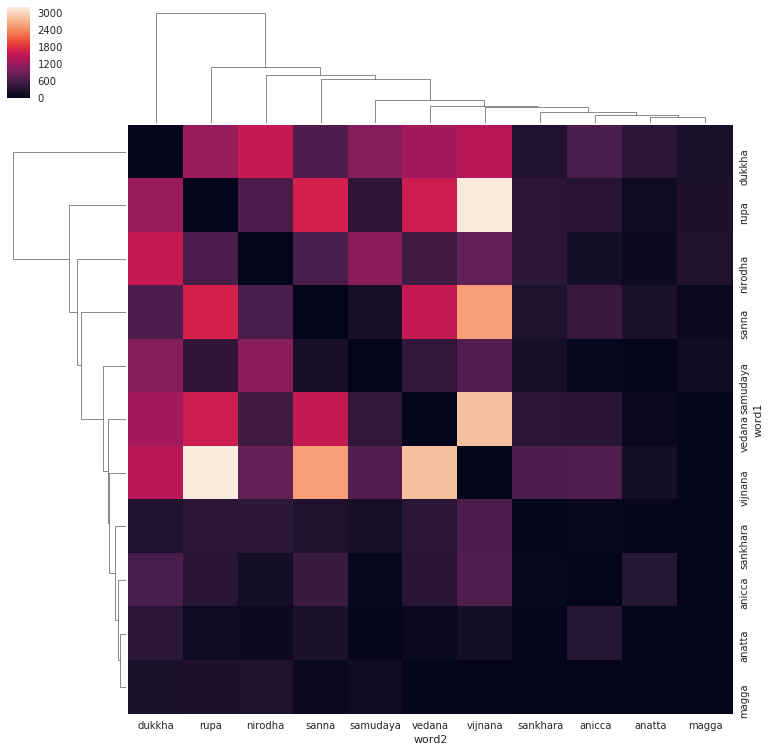

In [17]:
rcmd_figsize = (df_pivot.shape[0]+2,df_pivot.shape[1]+2)

sns.set(color_codes=True)

import scipy.spatial as sp
import scipy.cluster.hierarchy as hc

linkage = hc.linkage(sp.distance.squareform(df_pivot), method='single')

g = sns.clustermap(df_pivot,
                   row_linkage=linkage,
                   col_linkage=linkage,
                   figsize=rcmd_figsize)

g.savefig("output/img/test_matika_fournobletruths.png")

### Example: locating the suttas

In [18]:
location_query = query_keywordlist([
        "ekaṃ samayaṃ bhagavā"
    ])

results_location = search_documentlist(location_query, docs, sort="score")
print("Results found: {}".format(len(results_location)))

Results found: 680


In [19]:
dn_suttas_ids = []
mn_suttas_ids = []
an_suttas_ids = []
sn_suttas_ids = []

for doc in docs:
    sc_id = doc["dom"].get("id", None)
    if sc_id.startswith("dn"):
        dn_suttas_ids.append(sc_id)
    if sc_id.startswith("mn") and not sc_id.startswith("mnd"):
        mn_suttas_ids.append(sc_id)
    if sc_id.startswith("an"):
        an_suttas_ids.append(sc_id)
    if sc_id.startswith("sn") and not sc_id.startswith("snp"):
        sn_suttas_ids.append(sc_id)

print("dn: {}".format(len(dn_suttas_ids)))
print("mn: {}".format(len(mn_suttas_ids)))
print("an: {}".format(len(an_suttas_ids)))
print("sn: {}".format(len(sn_suttas_ids)))


dn: 34
mn: 152
an: 1366
sn: 1819


In [20]:
dn_suttas_located = []
mn_suttas_located = []
an_suttas_located = []
sn_suttas_located = []

for doc in results_location:
    sc_id = doc.get("doc_id", "")
    if sc_id.startswith("dn"):
        dn_suttas_located.append(sc_id)
    if sc_id.startswith("mn") and not sc_id.startswith("mnd"):
        mn_suttas_located.append(sc_id)
    if sc_id.startswith("an"):
        an_suttas_located.append(sc_id)
    if sc_id.startswith("sn") and not sc_id.startswith("snp"):
        sn_suttas_located.append(sc_id)

print("dn: {}".format(len(dn_suttas_located)))
print("mn: {}".format(len(mn_suttas_located)))
print("an: {}".format(len(an_suttas_located)))
print("sn: {}".format(len(sn_suttas_located)))

dn: 32
mn: 145
an: 173
sn: 224


In [21]:
print(set(dn_suttas_ids).difference(set(dn_suttas_located)))
print(set(mn_suttas_ids).difference(set(mn_suttas_located)))
#print(set(an_suttas_ids).difference(set(an_suttas_located)))

{'dn10', 'dn23'}
{'mn52', 'mn15', 'mn94', 'mn108', 'mn84', 'mn124', 'mn50'}


### Example: "yaṃ kiñci samuda­ya­dhammaṃ sabbaṃ taṃ nirodhadhamma"

In [22]:
formula_query = query_keywordlist([
        "yaṃ kiñci samuda­ya­dhammaṃ sabbaṃ taṃ nirodhadhamma"
    ])

results_formula = search_documentlist(formula_query, docs, sort="score")
print("Results found: {}".format(len(results_formula)))

with open("output/test_yam-kinci.md", "w") as ofile:
    ofile.write(result_markdown_formater(formula_query, results_formula))
    
[doc['doc_id'] for doc in results_formula]

Results found: 33


['cnd5',
 'cnd22',
 'cnd8',
 'dn14',
 'cnd9',
 'cnd23',
 'cnd12',
 'mnd13',
 'mnd15',
 'mil2',
 'cnd6',
 'mnd10',
 'mnd11',
 'dn5',
 'dn3',
 'dn21',
 'an8.12',
 'an8.22',
 'an8.21',
 'mn147',
 'mn91',
 'mn56',
 'mn74',
 'cnd16',
 'cnd20',
 'mnd16',
 'mnd14',
 'mnd4',
 'ud5.3',
 'sn56.11',
 'sn35.74',
 'sn35.121',
 'sn35.245']

In [23]:
formula_query = query_keywordlist([
        "yaṃ kho kiñci",
        "yampi hi kiñci",
        "yā kāci",
        "yaṃ kiñci",
        "ye keci",
        "samudayadhamma",
        "sabbaṃ taṃ",
        "nirodhadhamma"
    ])


results_formula = search_documentlist(formula_query, docs, sort="score")
print("Results found: {}".format(len(results_formula)))

dn_results_formula = [
    doc for doc in results_formula
    if (doc["doc_id"].startswith("dn"))
]
print("DN: {}".format([doc['doc_id'] for doc in dn_results_formula]))
with open("output/test_yam-kinci-DN.md", "w") as ofile:
    ofile.write(result_markdown_formater(formula_query, dn_results_formula))

mn_results_formula = [
    doc for doc in results_formula
    if (doc["doc_id"].startswith("mn") and not doc["doc_id"].startswith("mnd"))
]
print("MN: {}".format([doc['doc_id'] for doc in mn_results_formula]))
with open("output/test_yam-kinci-MN.md", "w") as ofile:
    ofile.write(result_markdown_formater(formula_query, mn_results_formula))

sn_results_formula = [
    doc for doc in results_formula
    if (doc["doc_id"].startswith("sn") and not doc["doc_id"].startswith("snp"))
]

print("SN: {}".format(sorted(
    [
        (doc['doc_id'])
        for doc in sn_results_formula
    ]
)))

with open("output/test_yam-kinci-SN.md", "w") as ofile:
    ofile.write(result_markdown_formater(formula_query, sn_results_formula))

Results found: 344
DN: ['dn14', 'dn21', 'dn5', 'dn3', 'dn16', 'dn9', 'dn19', 'dn23', 'dn20', 'dn29', 'dn2']
MN: ['mn109', 'mn101', 'mn38', 'mn35', 'mn52', 'mn91', 'mn147', 'mn56', 'mn74', 'mn37', 'mn22', 'mn62', 'mn76', 'mn33', 'mn119', 'mn54', 'mn121', 'mn8', 'mn115', 'mn106', 'mn66', 'mn28', 'mn107', 'mn65', 'mn136']
SN: ['sn1.37', 'sn1.39', 'sn12.20', 'sn12.31', 'sn12.32', 'sn12.34', 'sn12.70', 'sn16.11', 'sn18.21', 'sn18.22', 'sn2.30', 'sn2.8', 'sn20.1', 'sn20.12', 'sn22.102', 'sn22.124', 'sn22.125', 'sn22.126', 'sn22.127', 'sn22.128', 'sn22.21', 'sn22.48', 'sn22.49', 'sn22.59', 'sn22.71', 'sn22.72', 'sn22.79', 'sn22.82', 'sn22.91', 'sn22.92', 'sn22.95', 'sn24.5', 'sn24.71', 'sn24.96', 'sn35.121', 'sn35.135', 'sn35.245', 'sn35.246', 'sn35.33-42', 'sn35.74', 'sn36.11', 'sn36.2', 'sn36.21', 'sn4.1', 'sn41.10', 'sn42.11', 'sn44.2', 'sn45.104', 'sn45.110', 'sn45.116', 'sn45.122', 'sn45.128', 'sn45.134', 'sn45.139', 'sn45.140', 'sn45.141', 'sn45.146', 'sn45.149', 'sn45.150', 'sn45.96', 

In [24]:
#formula_reg = r"(ya|yā|ye)([^\.\'\"\“\”\‘\’\?]+)(kiñci|kāci|keci)([^\.\'\"\“\”\‘\’\?]+)sabbaṃ([^\:\.\'\"\“\”\‘\’\?]+)[\:\.\'\"\“\”\‘\’\?]"
formula_reg = r"(ya|yā|ye)([^\.\'\"\“\”\‘\’\?\;]+)(kiñci|kāci|keci)([^\.\'\"\“\”\‘\’\?]+)sabbaṃ([^\.\'\"\“\”\‘\’\?]+)(?:[\.\'\"\“\”\‘\’\?])?"

formula_query = query_regex(formula_reg)

full_results_formula = search_documentlist(formula_query, docs, sort="score")
print("Results found: {}".format(len(full_results_formula)))

print("Found in {}".format(sorted([doc["doc_id"] for doc in full_results_formula])))

def keep_doc(doc):
    if doc["doc_id"].startswith("dn"):
        return True
    if doc["doc_id"].startswith("mn") and not doc["doc_id"].startswith("mnd"):
        return True
    if doc["doc_id"].startswith("sn") and not doc["doc_id"].startswith("snp"):
        return True
    if doc["doc_id"].startswith("sn"):
        return True
    return False

results_formula = [doc for doc in full_results_formula if keep_doc(doc)]

print("DN,MN,SN,AN({}): {}".format(
    len(results_formula),
    sorted([doc["doc_id"] for doc in results_formula])
))

#for doc in results_formula:
#    for catchphrase in doc["catch"]:
#        print("*** formula in {} :\n{}".format(doc["doc_id"], catchphrase))

with open("output/test_yam-kinci-regex.md", "w") as ofile:
    ofile.write(result_markdown_formater(formula_query, sorted(results_formula, key=lambda d : d['doc_id'])))

Results found: 93
Found in ['an10.219', 'an3.133', 'an4.181', 'an4.196', 'an5.100', 'an8.12', 'an8.21', 'an8.22', 'an8.8', 'cnd12', 'cnd14', 'cnd16', 'cnd19', 'cnd20', 'cnd22', 'cnd23', 'cnd5', 'cnd6', 'cnd8', 'cnd9', 'dn14', 'dn16', 'dn21', 'dn3', 'dn5', 'ja519', 'ja527', 'mil2', 'mil3.7.14', 'mil5.1.4', 'mil5.1.6', 'mil5.1.9', 'mil6.1.3', 'mil6.1.5', 'mil6.3.1', 'mil6.4.2', 'mil7.3.8', 'mn106', 'mn109', 'mn147', 'mn22', 'mn33', 'mn35', 'mn56', 'mn62', 'mn74', 'mn91', 'mnd10', 'mnd11', 'mnd13', 'mnd14', 'mnd15', 'mnd16', 'mnd4', 'mnd9', 'ne37', 'pe1', 'pe5', 'ps1.1', 'ps2.6', 'ps3.1', 'sn12.70', 'sn16.11', 'sn18.21', 'sn18.22', 'sn22.102', 'sn22.124', 'sn22.125', 'sn22.49', 'sn22.59', 'sn22.71', 'sn22.72', 'sn22.79', 'sn22.82', 'sn22.91', 'sn22.92', 'sn24.71', 'sn24.96', 'sn35.121', 'sn35.245', 'sn35.74', 'sn4.1', 'sn41.10', 'sn42.11', 'sn44.2', 'sn55.39', 'sn55.6', 'sn56.11', 'snp2.14', 'snp3.12', 'thag16.1', 'thi-ap29', 'ud5.3']
DN,MN,SN,AN(44): ['dn14', 'dn16', 'dn21', 'dn3', 'dn5'